# 0.0. IMPORTS

In [74]:
import pandas as pd
import math
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
    
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Data Loading

In [4]:
file_sales = '../data/train.csv'
file_store = '../data/store.csv'

In [5]:
df_sales_raw = pd.read_csv(file_sales, low_memory=False)
df_store_raw = pd.read_csv(file_store, low_memory=False)

In [6]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
29331,342,7,2015-07-05,0,0,0,0,0,0,d,c,15770.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


# 1.0. DATA DESCRIPTION

## 1.1. Rename Columns

In [7]:
df = df_raw.copy()

In [8]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = df.columns
f_snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(f_snakecase, cols_old))
df.columns = cols_new
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [10]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of cols: {df.shape[1]}")

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [11]:
df.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. NA Check

In [14]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [15]:
df1 = df.copy()

In [16]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x:
                                                                                          x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                                          else x['competition_open_since_month'],
                                                                                          axis=1
                                                                                         )

#competition_open_since_year
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x:
                                                                                        x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                                        else x['competition_open_since_year'],
                                                                                        axis=1
                                                                                       )

#promo2_since_week
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x:
                                                                    x['date'].week if math.isnan(x['promo2_since_week'])
                                                                    else x['promo2_since_week'],
                                                                    axis=1
                                                                   )

#promo2_since_year
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x:
                                                                    x['date'].year if math.isnan(x['promo2_since_year'])
                                                                    else x['promo2_since_year'],
                                                                    axis=1
                                                                   )

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x:
                                                            0 if x['promo_interval'] == 0
                                                            else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                            else 0,
                                                            axis=1
                                                            )


In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [21]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [22]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
dp1 = pd.DataFrame(num_attributes.apply(np.std)).T
dp2 = pd.DataFrame(num_attributes.apply(min)).T
dp3 = pd.DataFrame(num_attributes.apply(max)).T
dp4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dp5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dp6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([dp2, dp3, dp4, ct1, ct2, dp1, dp5, dp6]).T.reset_index()
m.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


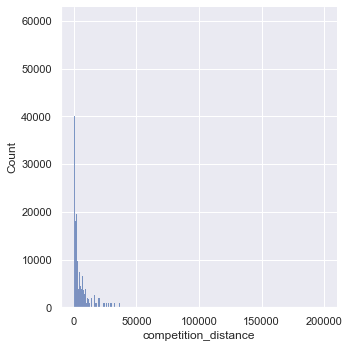

In [23]:
sns.displot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

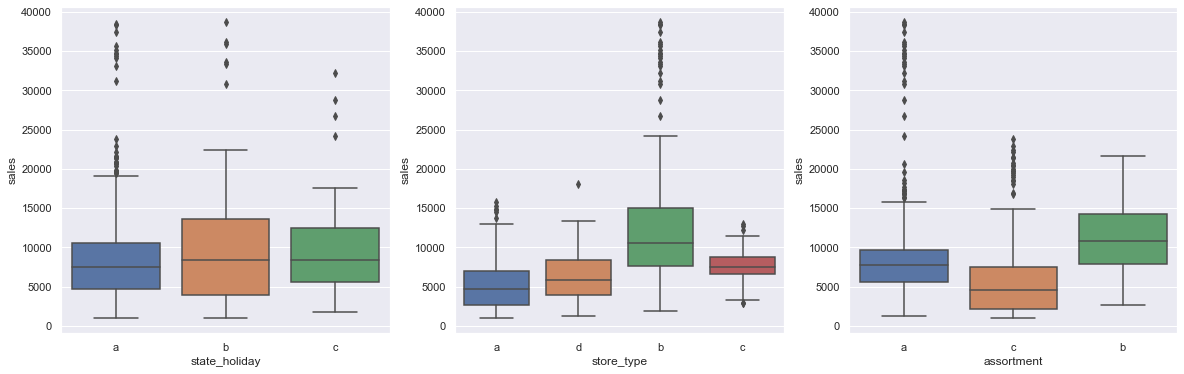

In [25]:
plt.figure(figsize=(20, 6))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

#plt.subplot(2, 2, 1)
#sns.boxplot(x='promo_interval', y='sales', data=aux1)

#plt.subplot(2, 2, 2)
#sns.boxplot(x='month_map', y='sales', data=aux1)


# 2.0. FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

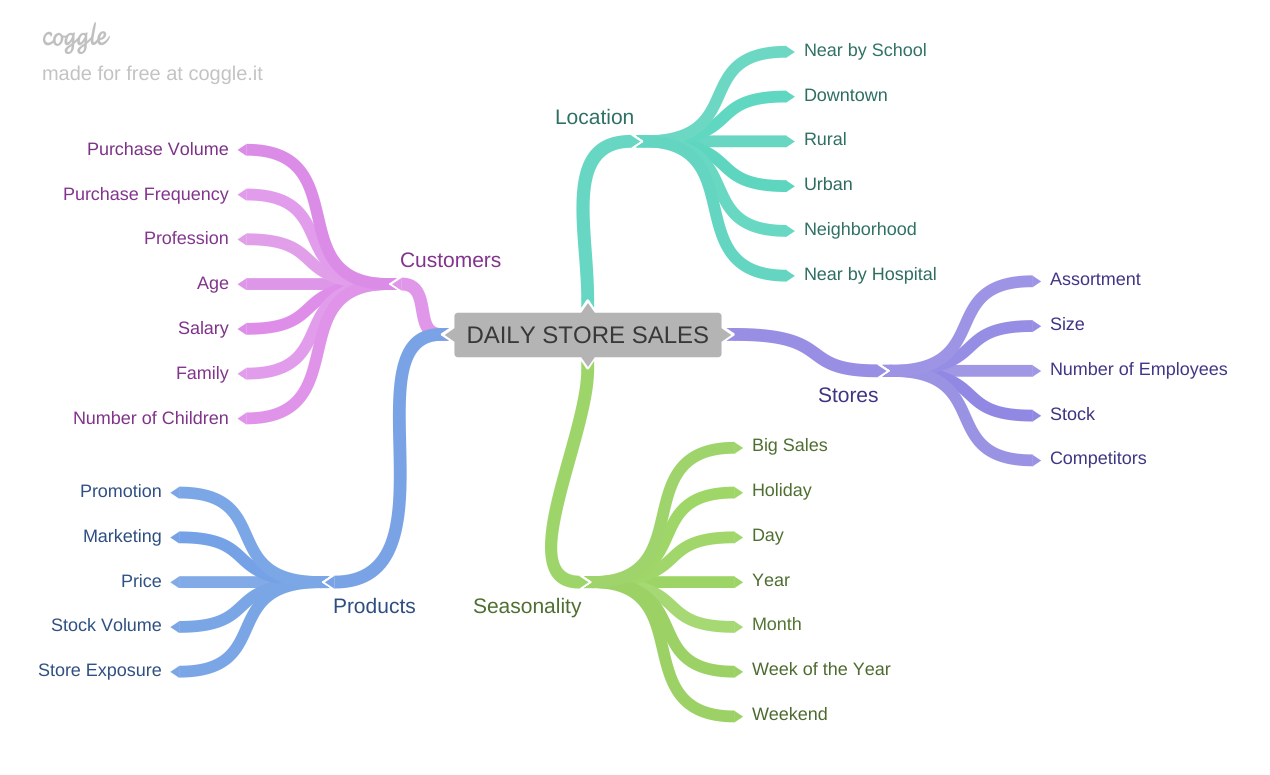

In [27]:
Image('../img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Store with more employees should sell more

**2.** Store with big stock should sell more

**3.** Big store should sell more

**4.** Small store should sell less

**5.** Store with big assortment should sell more

**6.** Store with close competitors should sell less

**7.** Store with competitors for a long time should sell more

### 2.2.2. Product Hypothesis

**1.** Store that more invest in marketing should sell more

**2.** Store that more exposes its products in the showcase should sell more

**3.** Store that has small prices should sell more

**4.** Store that has small prices for a long period should sell more

**5.** Store with active promotion for a long time should sell more

**6.** Store with more days in promotion should sell more

**7.** Store with consecutive promotion should sell more

### 2.2.3. Time Hypothesis

**1.** Store in places with more holidays should sell less

**2.** Store that opens in the first 6 months of the year should sell more

**3.** Store opened during Christmas should sell more

**4.** Store should sell more through the years

**5.** Store should sell more in the second semester of the year

**6.** Store should sell more after the 10th day of each month

**7.** Store should sell less on weekends

**8.** Store should sell less during the school holidays

## 2.3. Final List of Hypothesis

**1.** Store with big assortment should sell more

**2.** Store with close competitors should sell less

**3.** Store with competitors for a long time should sell more

**4.** Store with active promotion for a long time should sell more

**5.** Store with more days in promotion should sell more

**6.** Store with consecutive promotion should sell more

**7.** Store opened during Christmas should sell more

**8.** Store should sell more through the years

**9.** Store should sell more in the second semester of the year

**10.** Store should sell more after the 10th day of each month

**11.** Store should sell less on weekends

**12.** Store should sell less during the school holidays

## 2.4. Feature Engineering

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                month=x['competition_open_since_month'],
                                day=1),
    axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /
                                 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'
                                         ) - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                          7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday'
    if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [29]:
df2.sample(9).T

,452769,76615,363129,683373,487053,327822,811305,767272,67536
store,865,796,626,664,584,895,371,938,637
day_of_week,4,7,1,7,1,4,4,2,1
date,2014-05-22 00:00:00,2015-05-24 00:00:00,2014-08-18 00:00:00,2013-10-27 00:00:00,2014-04-21 00:00:00,2014-09-25 00:00:00,2013-07-04 00:00:00,2013-08-13 00:00:00,2015-06-01 00:00:00
sales,7217,0,15072,0,0,6972,8932,11166,11593
customers,592,0,1185,0,0,786,699,1086,818
open,1,0,1,0,0,1,1,1,1
promo,1,0,1,0,0,0,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,easter_holiday,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,1,0,1,0,0,0,1
store_type,d,a,c,d,d,a,d,a,d


# 3.0. FILTERING OF VARIABLES

In [30]:
df3 = df2.copy()

## 3.1. Filteting Lines

In [31]:
df3 = df3[(df3['open'] != 0) & (df['sales'] > 0)]

## 3.2. Filtering Columns

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [33]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4.0. Exploratory Data Analysis

In [34]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

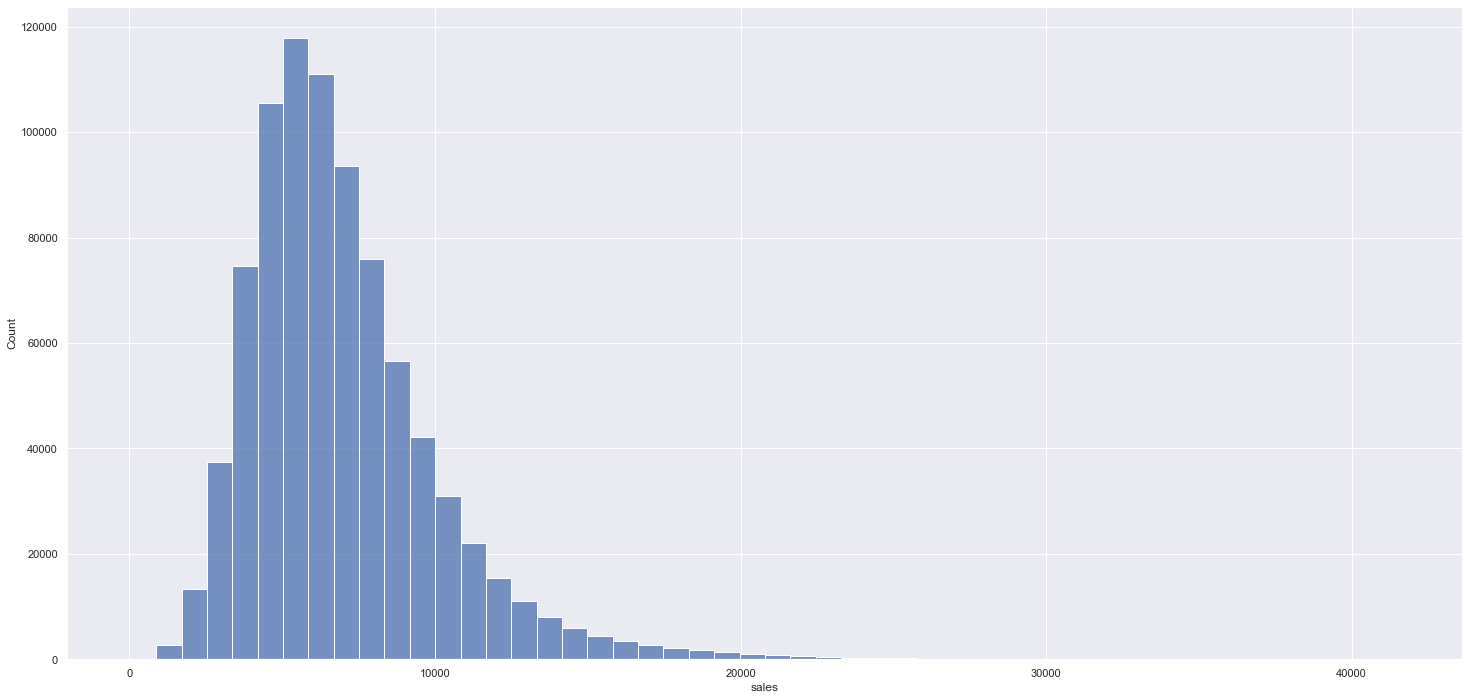

In [35]:
sns.histplot(df4['sales'], bins=50);

### 4.1.2. Numerical Variable

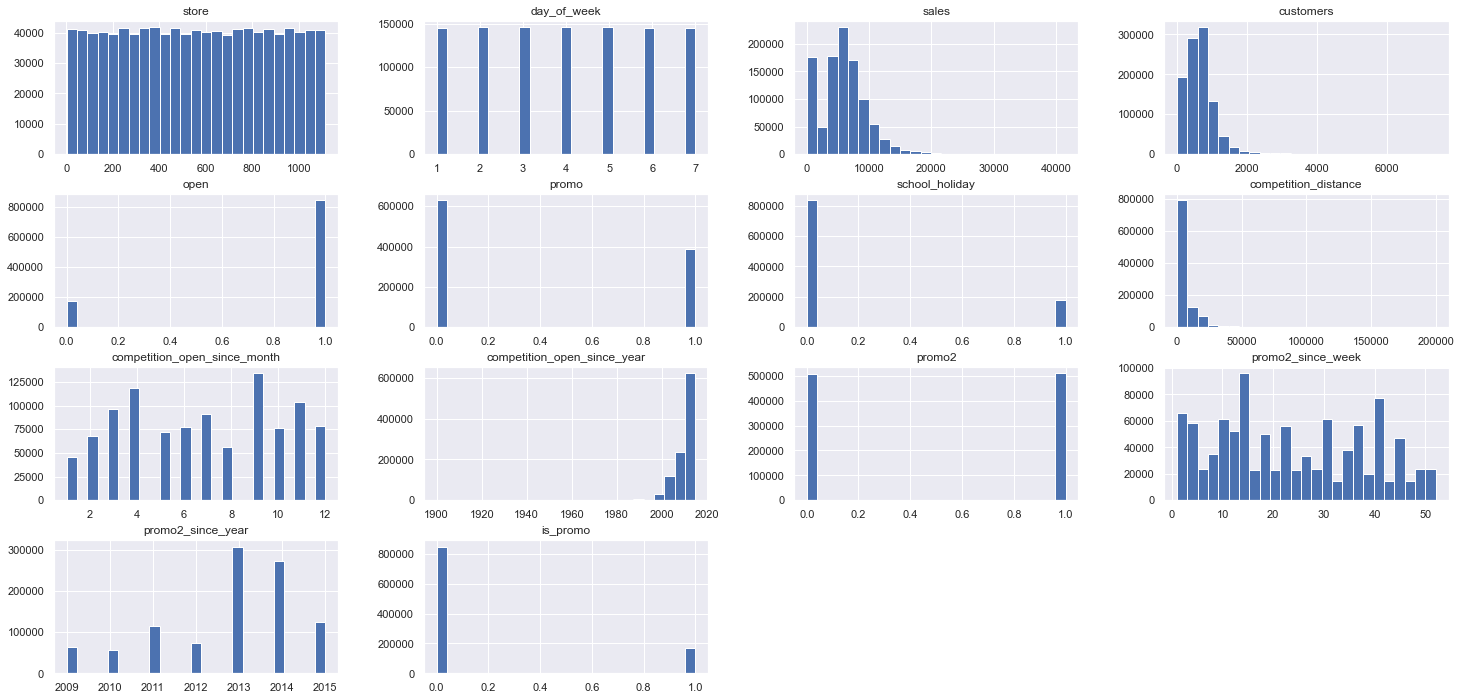

In [36]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variable

In [37]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

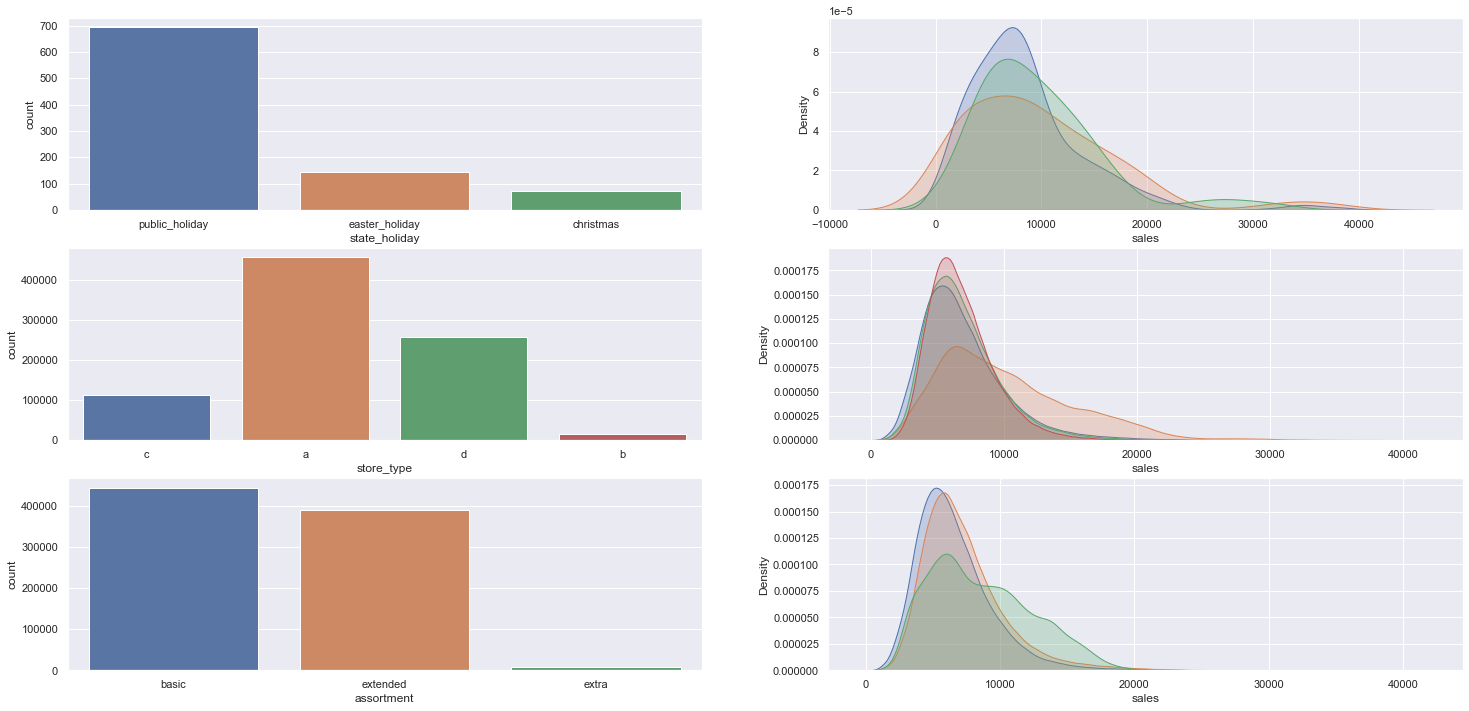

In [38]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='exra', shade=True)

## 4.2. Bivariate Analysis

### 4.2.1. Hypothesis Test

#### H1. Store with big assortment should sell more
**FALSE!** Store with BIG ASSORTMENT sells LESS 

<AxesSubplot:xlabel='year_week'>

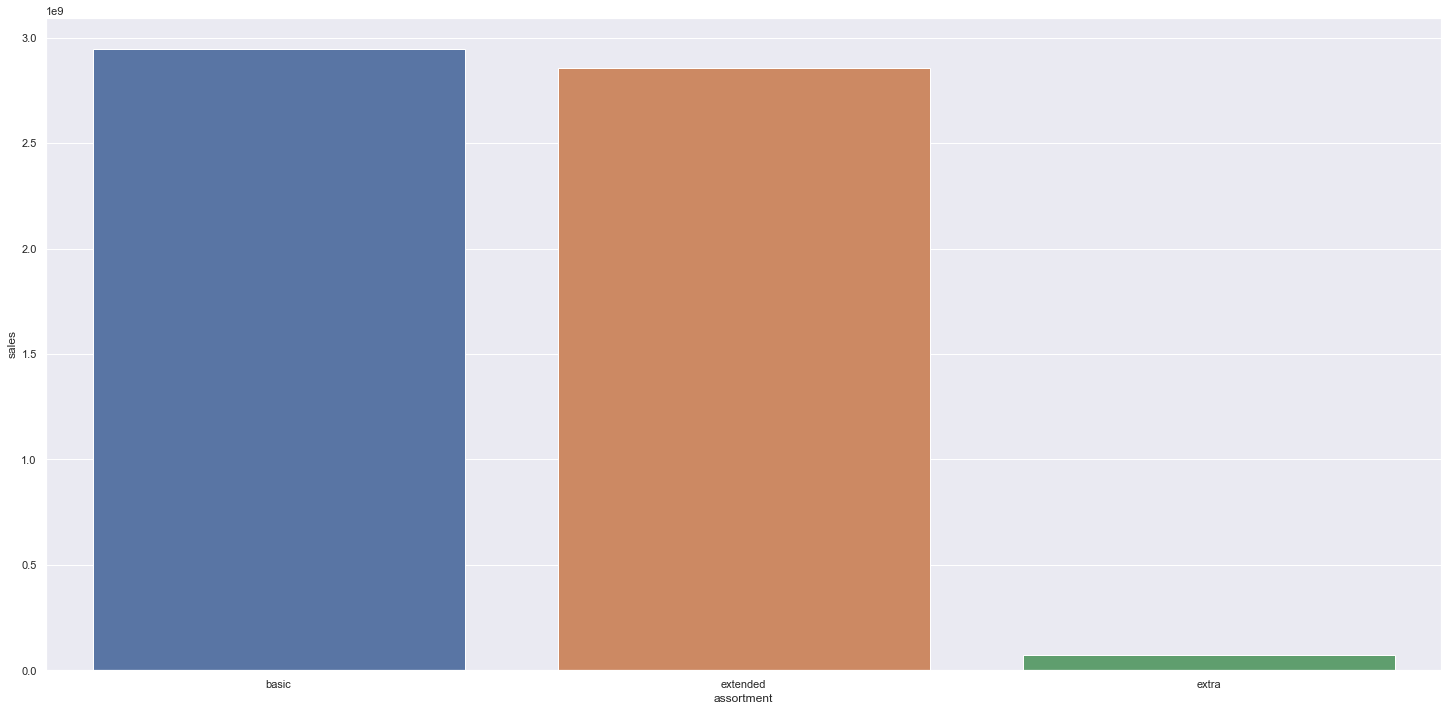

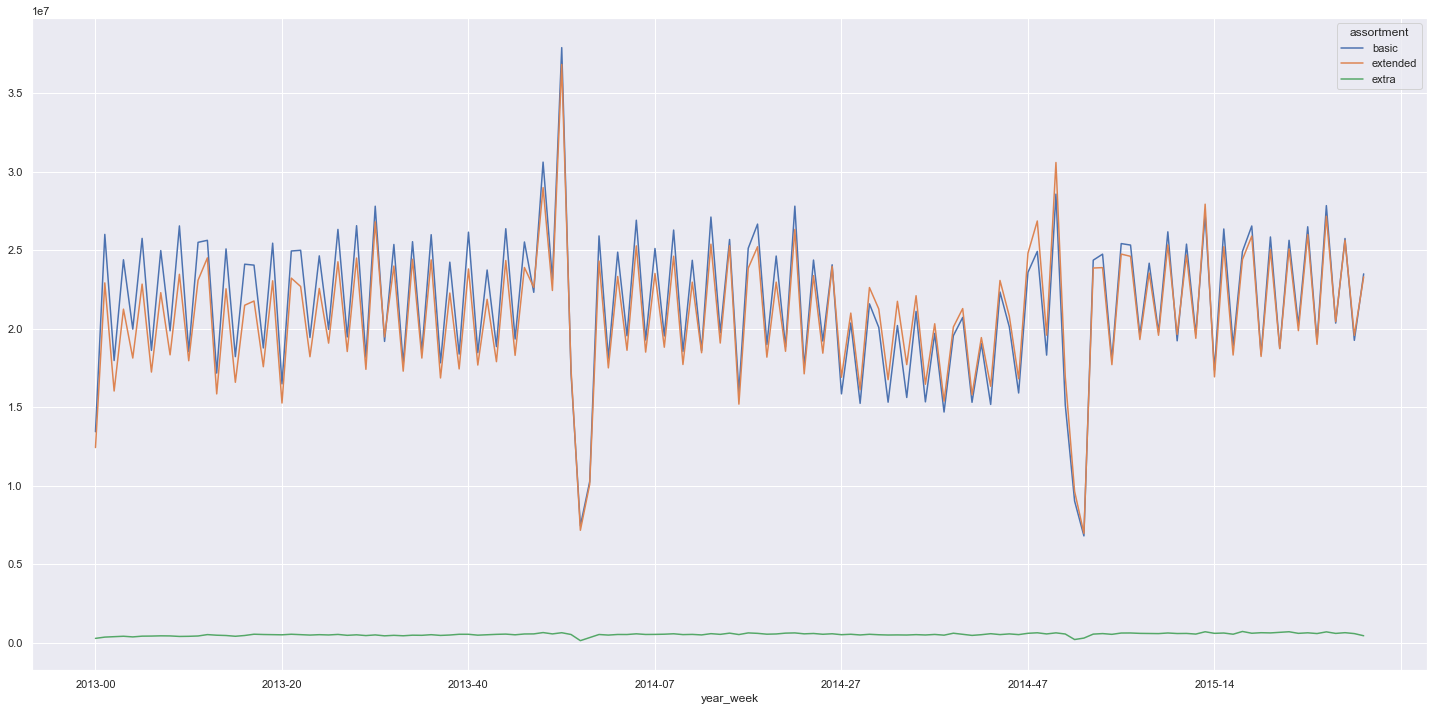

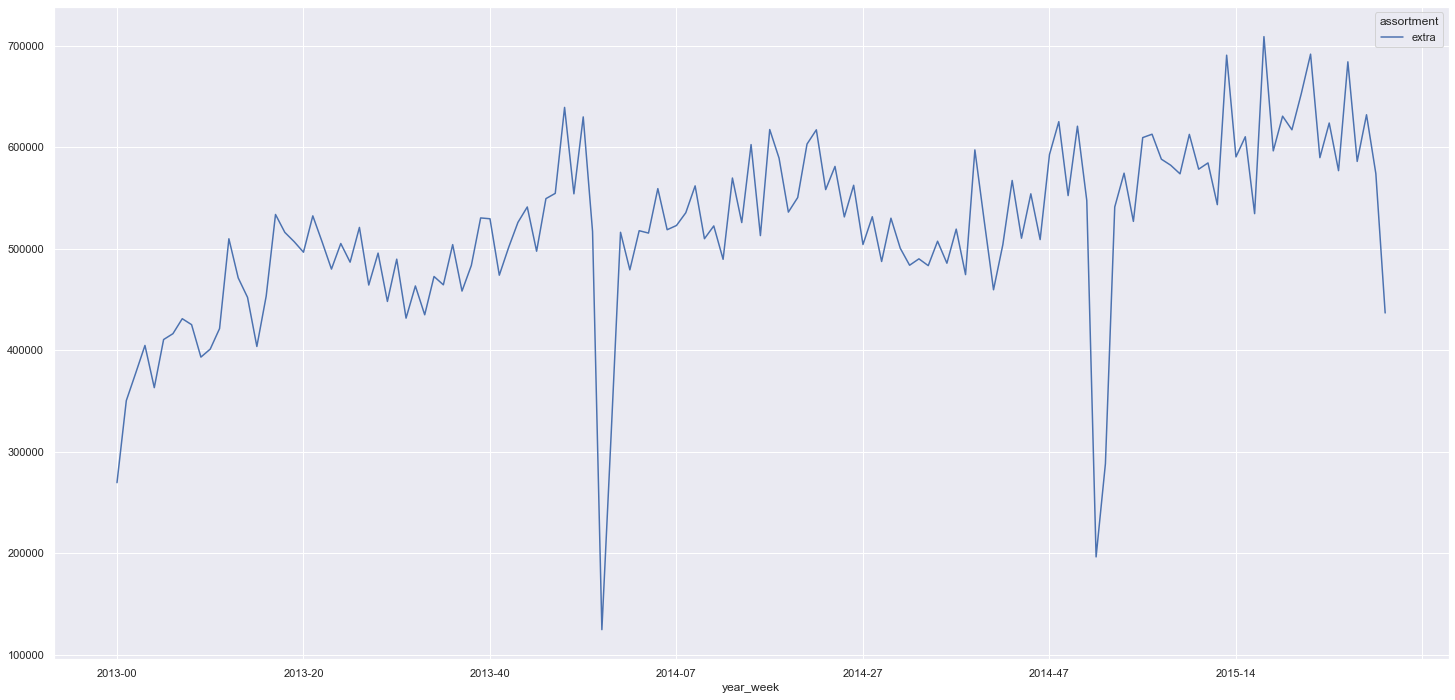

In [39]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

#### H2. Store with close competitors should sell less
**FALSE!** Store with CLOSE COMPETITIOS sells MORE

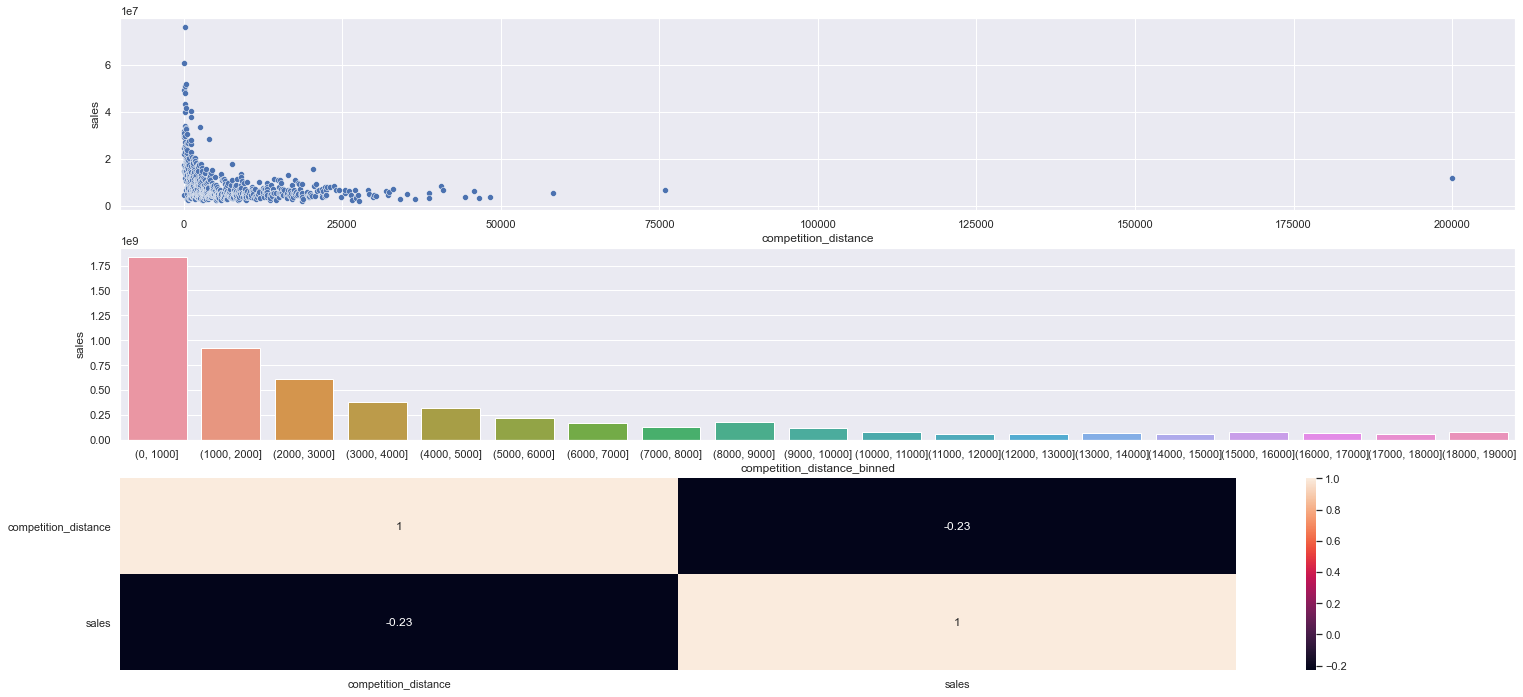

In [40]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(3, 1, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(3, 1, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
#plt.xticks(rotation = 90)

plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H3. Store with competitors for a long time should sell more
**FALSE!** Store with COMPETITIORS FOR A LONG TIME sells LESS

<AxesSubplot:>

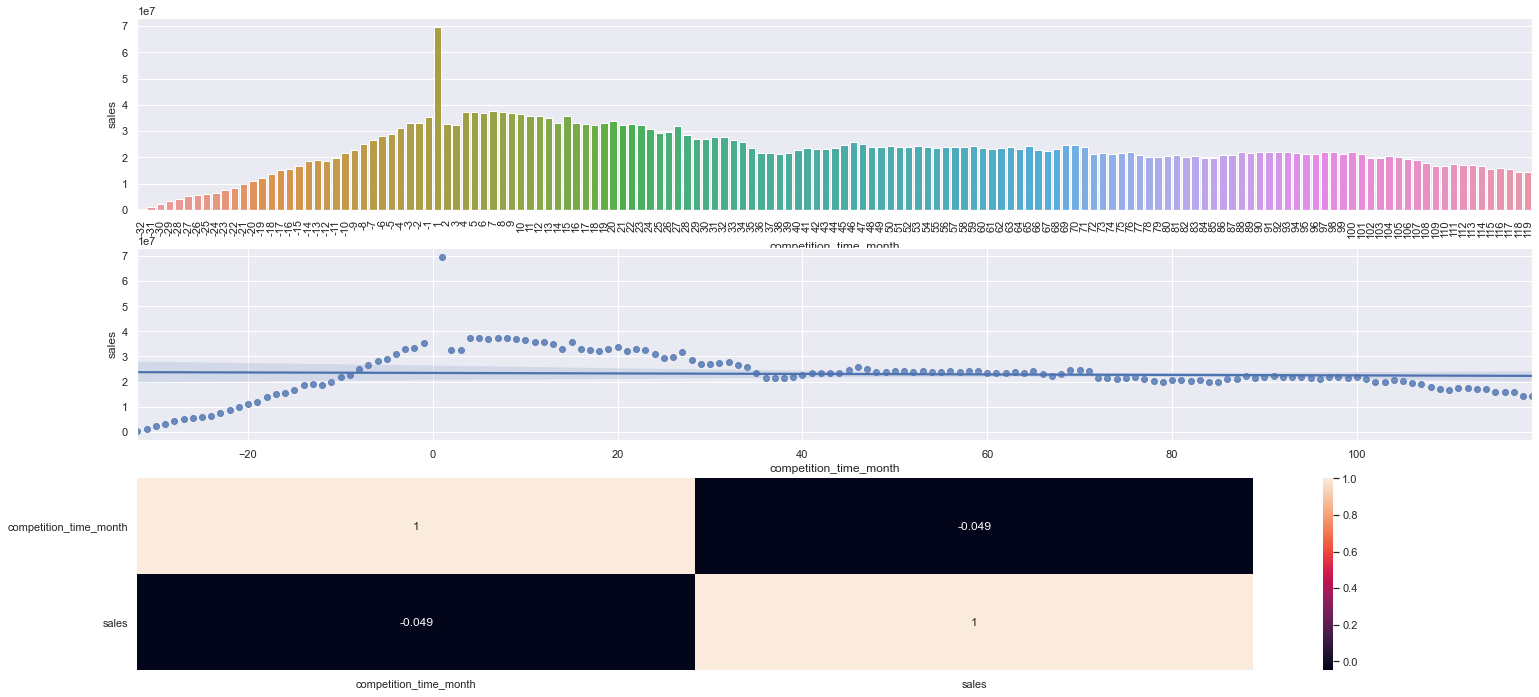

In [41]:
plt.subplot(3, 1, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(3, 1, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(3, 1, 3)
sns.heatmap(aux2.corr(method = 'pearson'), annot = True)

#### H4. Store with active promotion for a long time should sell more
**FALSE!** Store with PROMO for LONG TIME sells REGULARLY and DECREASE after some time

<AxesSubplot:>

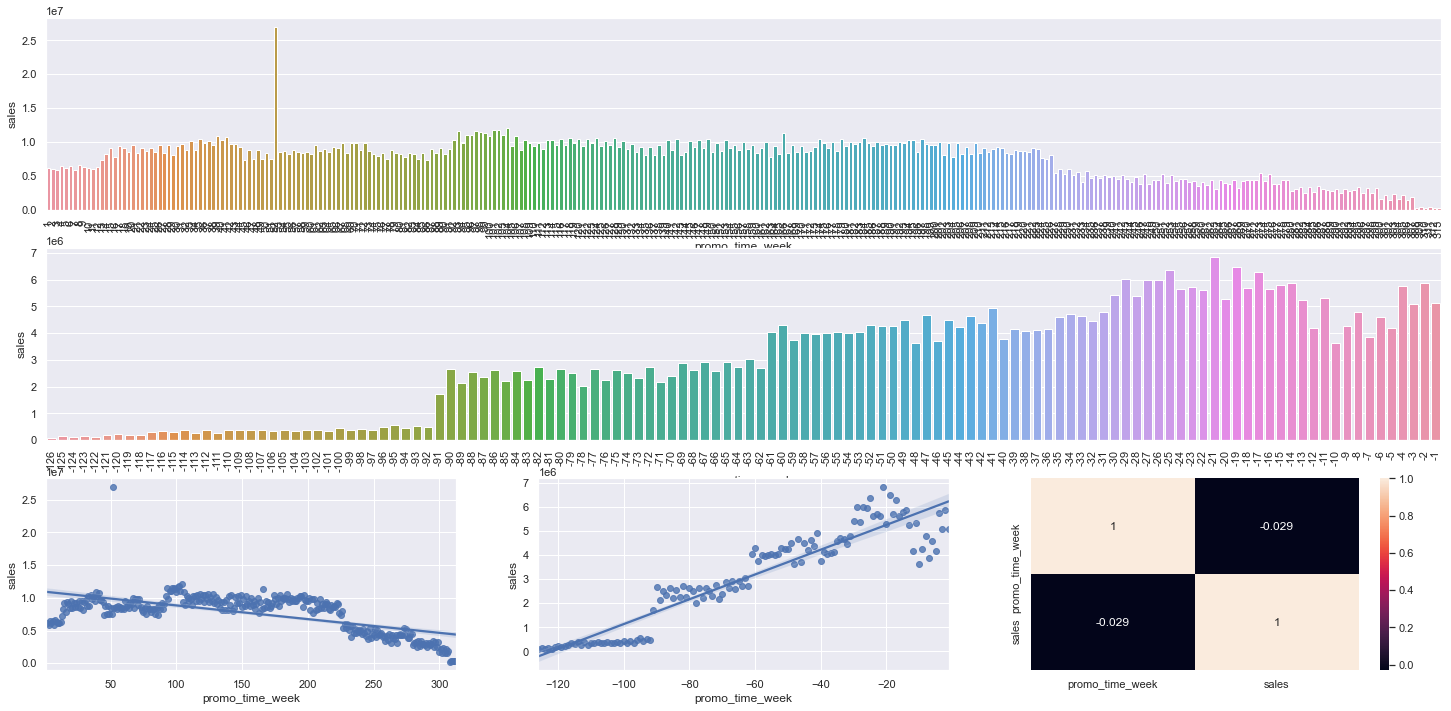

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);

grid = GridSpec(3, 3)

plt.subplot(grid[0, :])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90)

plt.subplot(grid[2, 0])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1, :])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90)

plt.subplot(grid[2, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[2, 2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### <S>H5. Store with more days in promotion should sell more</S>

#### H6. Store with consecutive promotion should sell more
**FALSE!** Store with CONSECUTIVE PROMO sells LESS

In [43]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


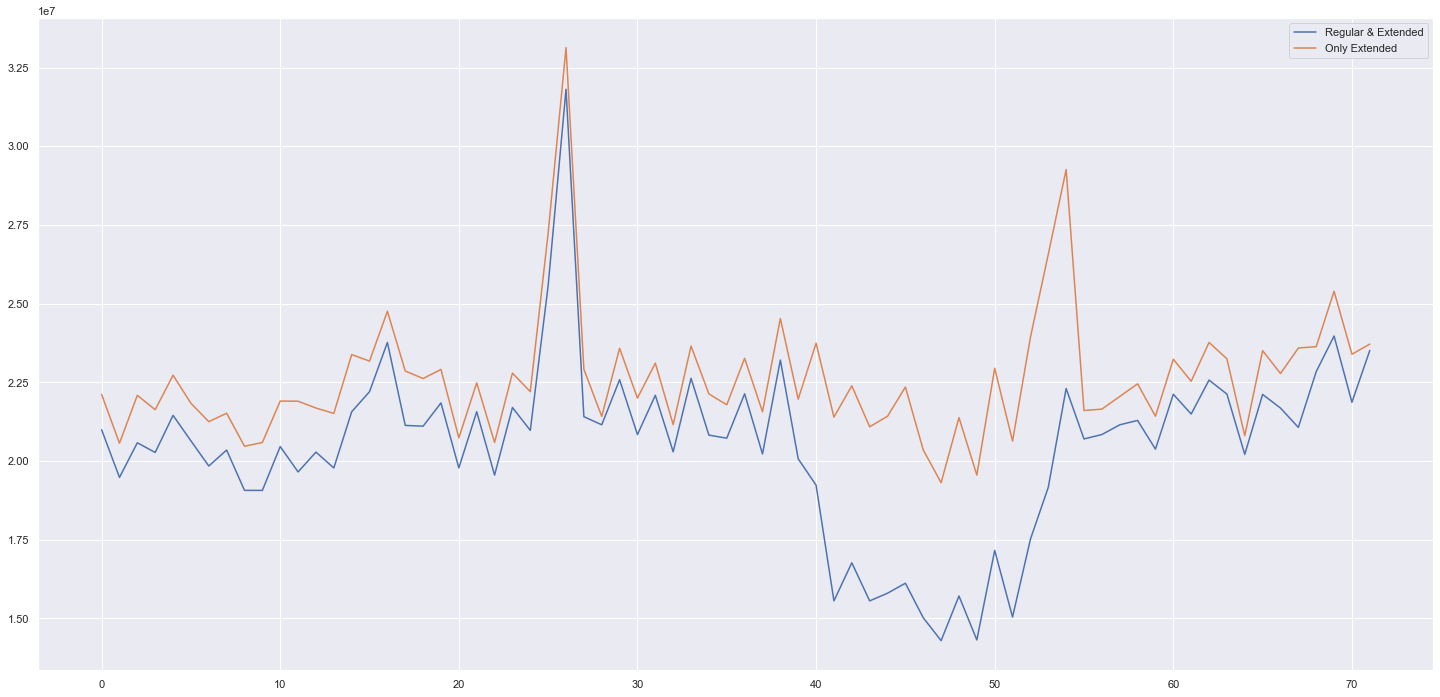

In [44]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Regular & Extended', 'Only Extended']);

#### H7. Store opened during Christmas should sell more
**FALSE!** Store opened DURING CHRISTMAS sells LESS

<AxesSubplot:xlabel='year', ylabel='sales'>

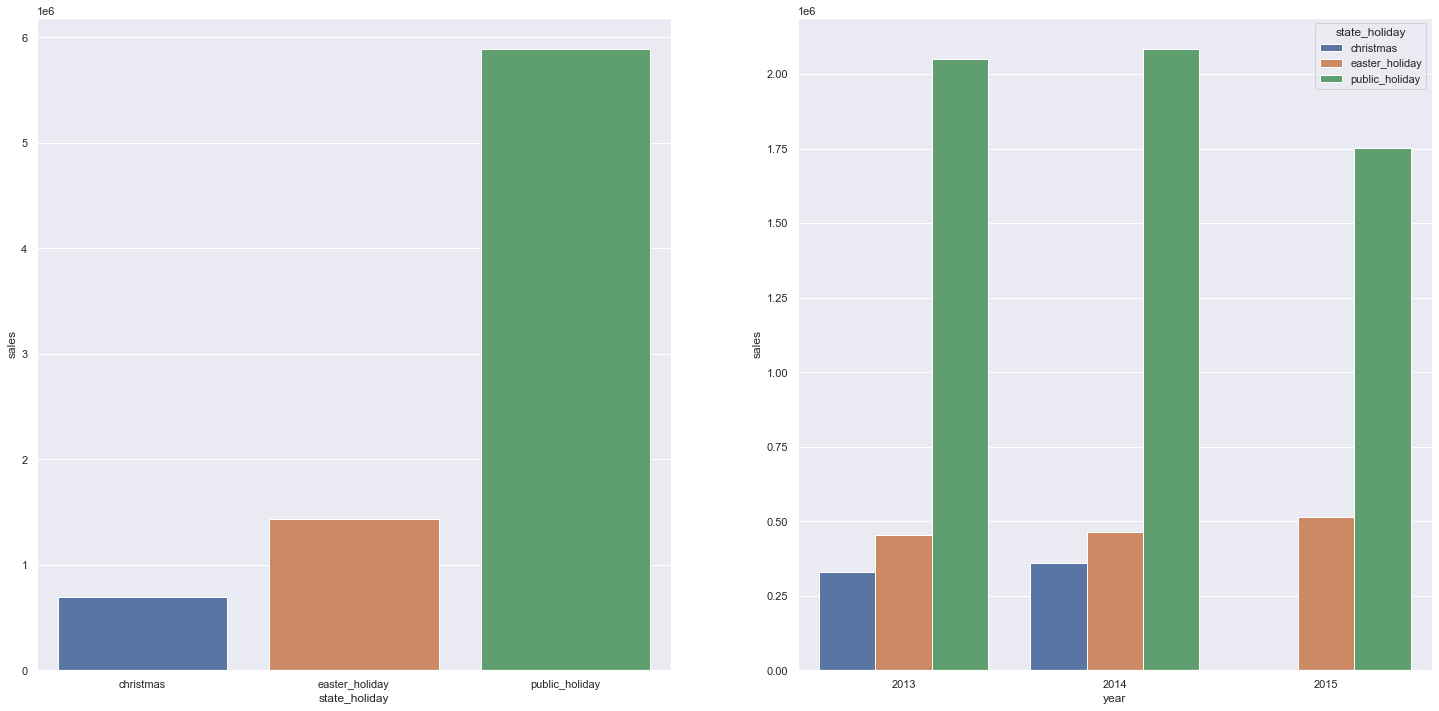

In [45]:
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux2, hue = 'state_holiday')

#### H8. Store should sell more through the years
**FALSE!** Store sells LESS THROUGH THE YEARS

<AxesSubplot:>

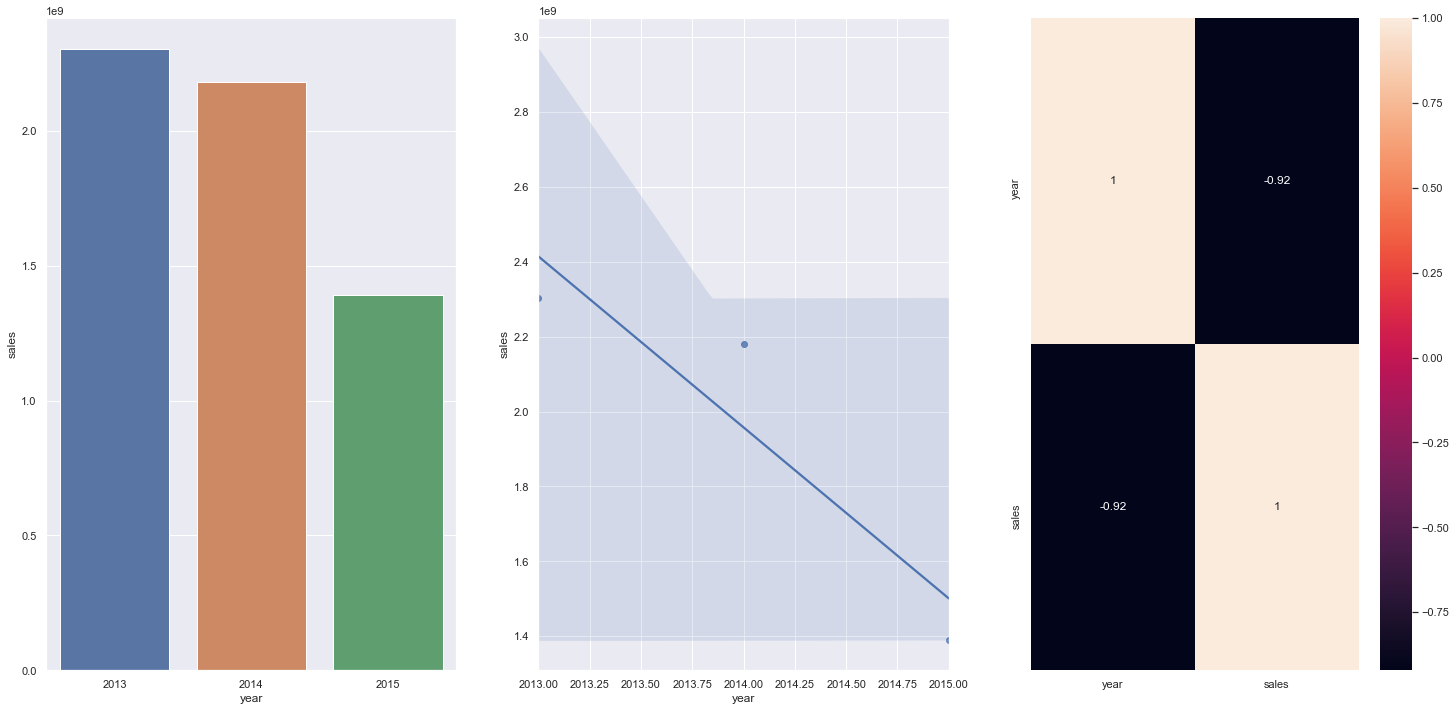

In [46]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### H9. Store should sell more in the second semester of the year
**FALSE!** Store sells LESS in the SECOND SEMESTER

<AxesSubplot:>

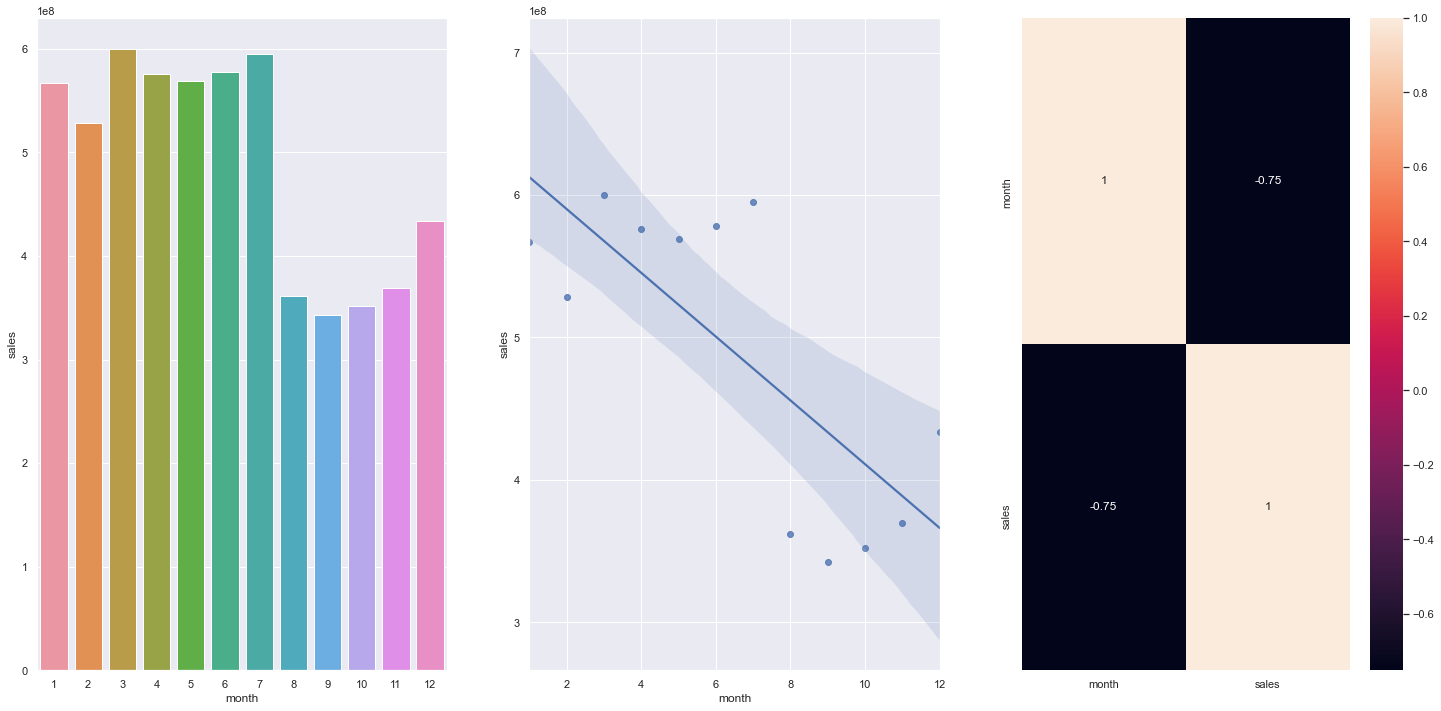

In [47]:
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### H10. Store should sell more after the 10th day of each month
**TRUE!**

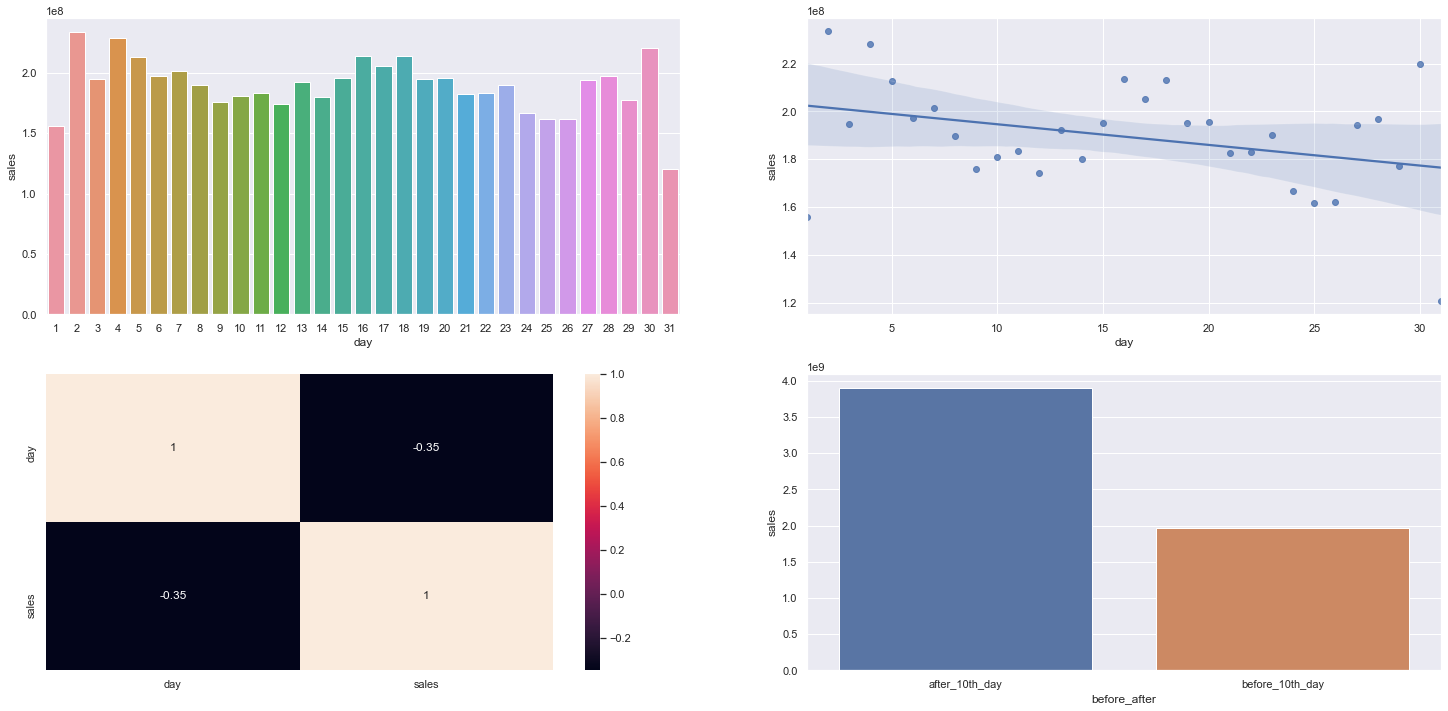

In [48]:
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

#### H11. Store should sell less on weekends
**TRUE!**

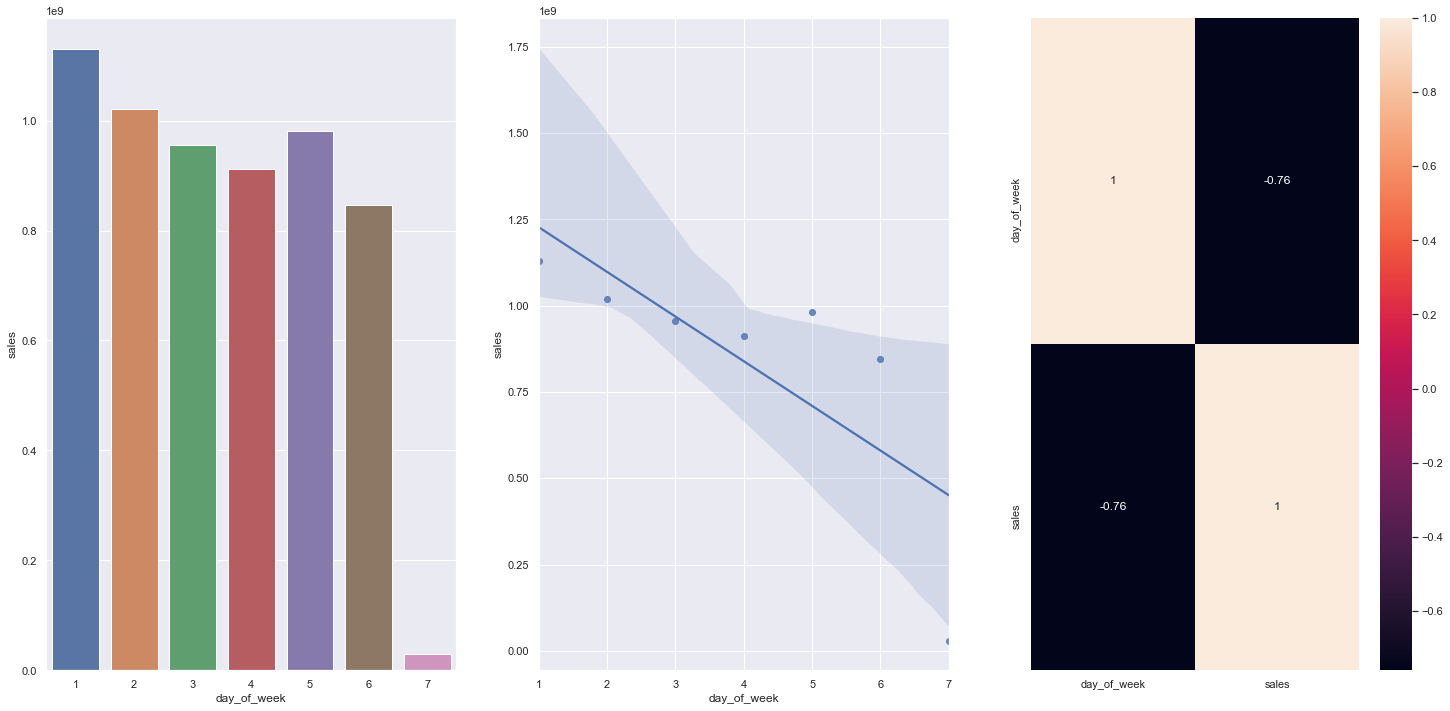

In [49]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H12. Store should sell less during the school holidays
**TRUE!** Store sells LESS DURING the SCHOOL HOLIDAYS. Except for july and august.

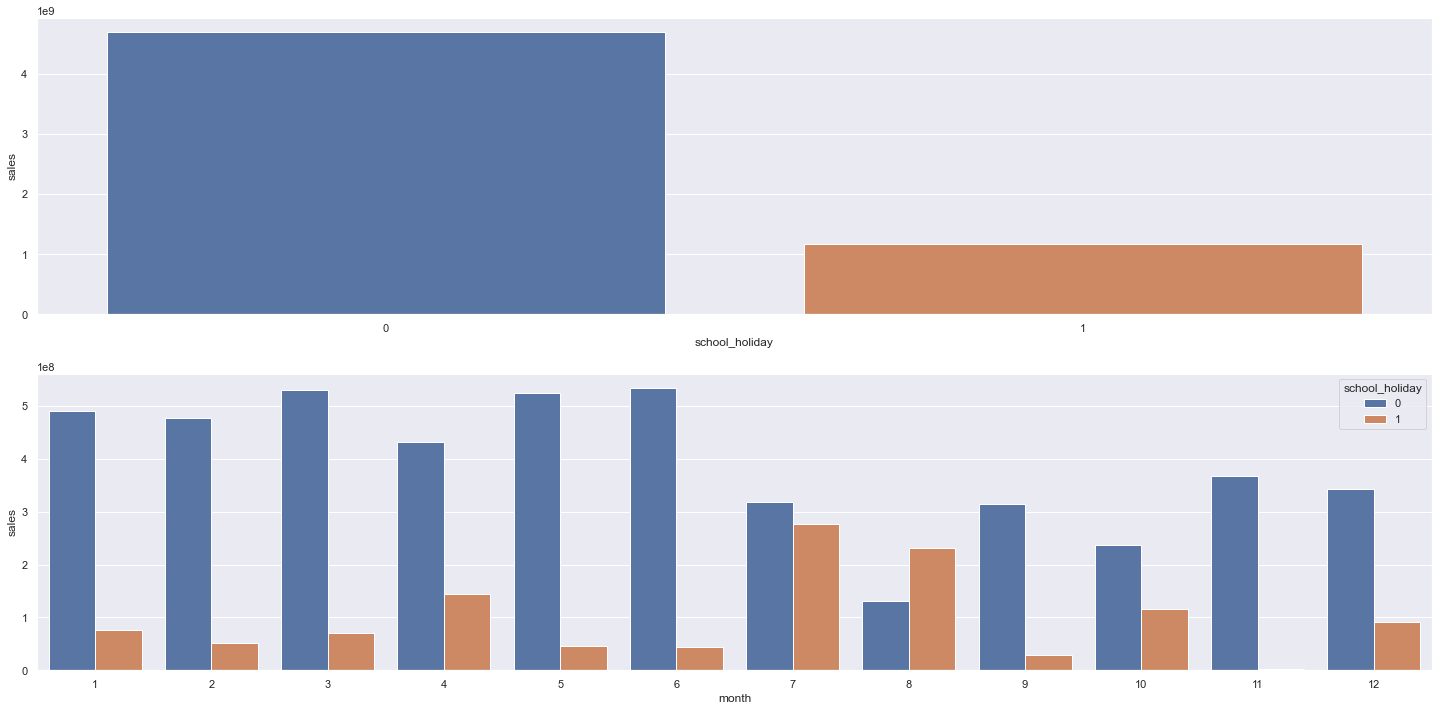

In [50]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux2, hue = 'school_holiday');

### 4.2.2. Hypothesis Summary

In [51]:
tab = [
    ['Hypothesis', 'Veredict', 'Relevance'],
    ['H1', 'False', 'Low'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Medium'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', 'False', 'Low'],
    ['H7', 'False', 'Medium'],
    ['H8', 'False', 'High'],
    ['H9', 'False', 'High'],
    ['H10', 'True', 'High'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Low']
]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Veredict    Relevance
------------  ----------  -----------
H1            False       Low
H2            False       Medium
H3            False       Medium
H4            False       Low
H5            -           -
H6            False       Low
H7            False       Medium
H8            False       High
H9            False       High
H10           True        High
H11           True        High
H12           True        Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

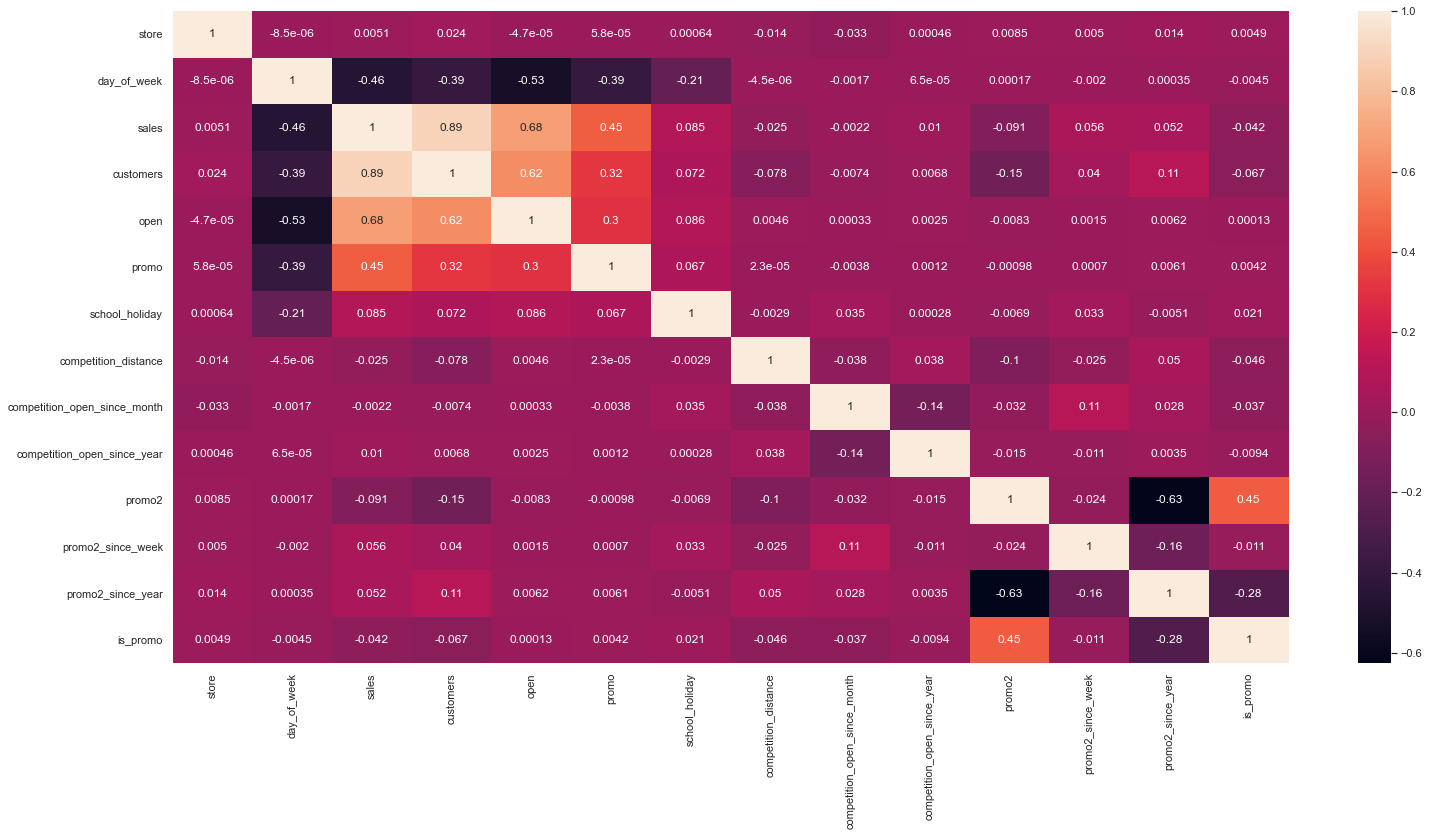

In [52]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

In [53]:
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [54]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]             
             })

d = d.set_index(d.columns)

d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

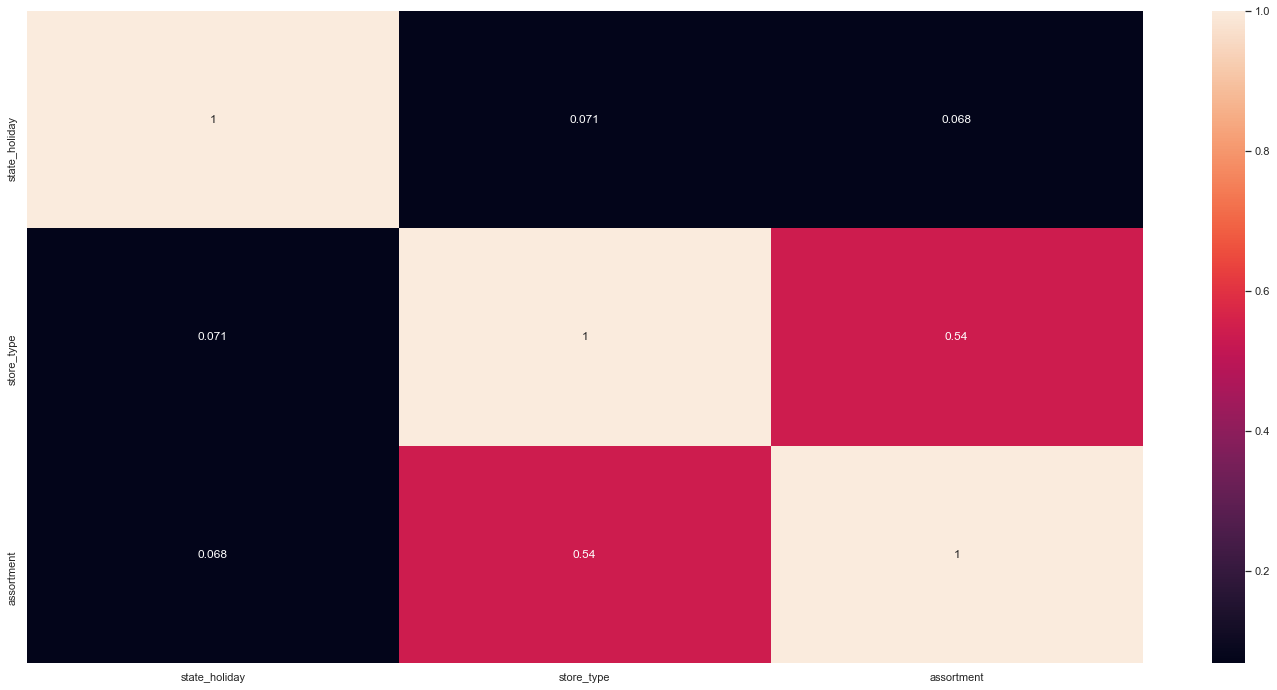

In [55]:
sns.heatmap(d, annot = True)

# 5.0 DATA PREPARATION

In [81]:
df5 = df4.copy()

## 5.1. Standardize

As the numerical attributes are not normal, it was defined that will not be needed to standardize them

## 5.2. Rescaling

In [82]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance: robust scaler (it has outliers)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# year: min max scaler (it has not relevant outliers)
df5['year'] = mms.fit_transform(df5[['year']].values)

# competition time month: robust scaler (it has outliers)
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week: min max scaler (it has not relevant outliers)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

## 5.3. Transform

### 5.3.1. Encoding

In [83]:
le = LabelEncoder()

# state_holiday: one hot encoding (status change)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type: label encoder (it has no relation between the levels of the variable)
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment: ordinal encoder (it has ordinal relation between the levels[extended > extra > basic])
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transform

In [84]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transform

In [85]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# 6.0. Feature Selection

In [86]:
df6 = df5.copy()

## 6.1. Split the Dataframe into training and test

In [87]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [68]:
# getting the date of 6 weeks before the last date in the dataframe
cut_date = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

In [71]:
# training dataset
x_train = df6[df6['date'] < cut_date]
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= cut_date]
y_test = x_test['sales']

print(f"Training Min Date: {x_train['date'].min()}")
print(f"Training Max Date: {x_train['date'].max()}")

print(f"\nTraining Min Date: {x_test['date'].min()}")
print(f"Training Max Date: {x_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [75]:
# # training and test dataset for Boruta
# x_train_n = x_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	0
Rejected: 	9


In [76]:
cols_selected = boruta.support_.tolist()

x_train_fs = x_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Features Selected

In [88]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# features to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [89]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_opne_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

In [ ]:
cols_selected_boruta_full